## Training and export Sneaker Wizard Model

This juypter notebook will be used to train and deploy our "sneaker wizard" model! Please refer to this notebook once you have downloaded the training images! :)


Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Like before lets import all the necessary packages; fastai V1 library with Pytorch and matplotlib. We'll also set the working `path` to our `dataset/sneakers` directory where all our training images are stored. 

In [3]:
from fastai import *
from fastai.vision import *
import matplotlib.pyplot as plt

In [4]:
path = Path('dataset/sneakers-cropped')

You may get an out of memory error. If this happens, click Kernel -> Restart, uncomment the 2nd line to use a smaller "batch size" and try running the notebook again.

In [5]:
bs = 64
# bs = 16

## View data

Lets get a better understanding of our dataset from the downloaded set of training images. Here we'll use the ImageDataBunch function to create a validation set, view our data, and transform our images.

We'll list out all the sneaker classes, number of classes, number of images in the training set and in the validation set. We'll also view a sample set of our images. 

In [6]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=299, bs=bs//2, num_workers=4).normalize(imagenet_stats)

In [7]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Adidas_Human_Race_NMD_Pharrell_x_Chanel',
  'Air_Fear_of_God_1_Sail_Black',
  'Air_Force_1_Off-White_Volt',
  'Air_Max_1_97_Sean_Weatherspoon',
  'Air_Max_1_Atmos_Animal_Pack',
  'Air_Max_1_Atmos_Elephant',
  'Air_Max_1_Atmos_Supreme_Animal_Pack',
  'Air_Max_90_Infrared',
  'Air_Max_90_Off-White_Black',
  'Air_Max_90_Off-White_Desert_Ore',
  'Air_Max_97_Shanghai_Kaleidoscope',
  'Air_Max_97_Silver_Bullet',
  'Air_Presto_Off-White_Black',
  'Air_Presto_Off-White_Ten',
  'Air_Presto_Off-White_White',
  'Air_Vapormax_Off-White_White',
  'Air_Yeezy_2_Red_October',
  'Air_Zoom_Fly_SP_Off-White_Tulip_Pink',
  'Air_Zoom_Terra_Kiger_5_Off-White_Black',
  'Converse_Chuck_70_Off-White_White',
  'Converse_Comme_Des_Garcons',
  'Jordan_1_Retro_High_Off-White_University_Blue',
  'Jordan_1_Retro_High_Travis_Scott',
  'Jordan_3_Retro_Og_Black_Cement',
  'Jordan_4_Retro_Bred',
  'Jordan_4_Retro_Og_White_Cement',
  'Jordan_6_Retro_Infrared',
  'Nike_LD_Waffle_Sacai_Blue_Multi',
  'Nike_React_Element

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/fastai/vision/data.py:306: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


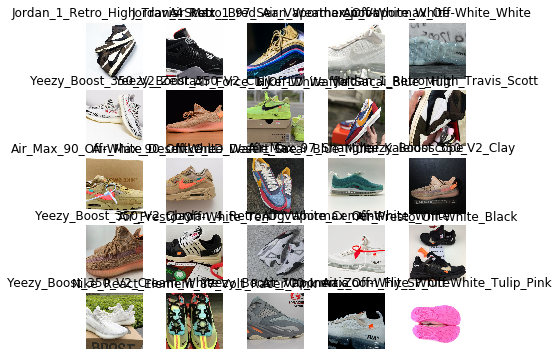

In [8]:
data.show_batch(rows=5, figsize=(7,6))

## Training: Resnet101

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) to build a model which will take images as input and will output the predicted probability for each of the categories. 

We will train for 5 epochs (5 cycles through all our data) and save our model.

In [9]:
# Create convolutional network resnet 101; can specify to something different
learn2 = cnn_learner(data, models.resnet101, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/ec2-user/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:02<00:00, 65354320.11it/s]


In [10]:
learn2.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [12]:
learn2.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.232282,0.118779,0.025600,01:34
1,0.175335,0.076820,0.018400,01:31
2,0.102108,0.062559,0.012000,01:32
3,0.061052,0.065620,0.013600,01:30
4,0.029037,0.087601,0.016800,01:31


In [13]:
learn2.save('stage-1-res101')

## Results

Let's see what results we have got. 

We will first plot the model's top losses; categories that the model most confused with one another. In our case the mistakes look reasonable which is an indicator that our classifier is working correctly.

Once we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes but it rarely confuses other categories. The model finds it difficult to classify some specifc categories between each other. 

In [14]:
interp = ClassificationInterpretation.from_learner(learn2)

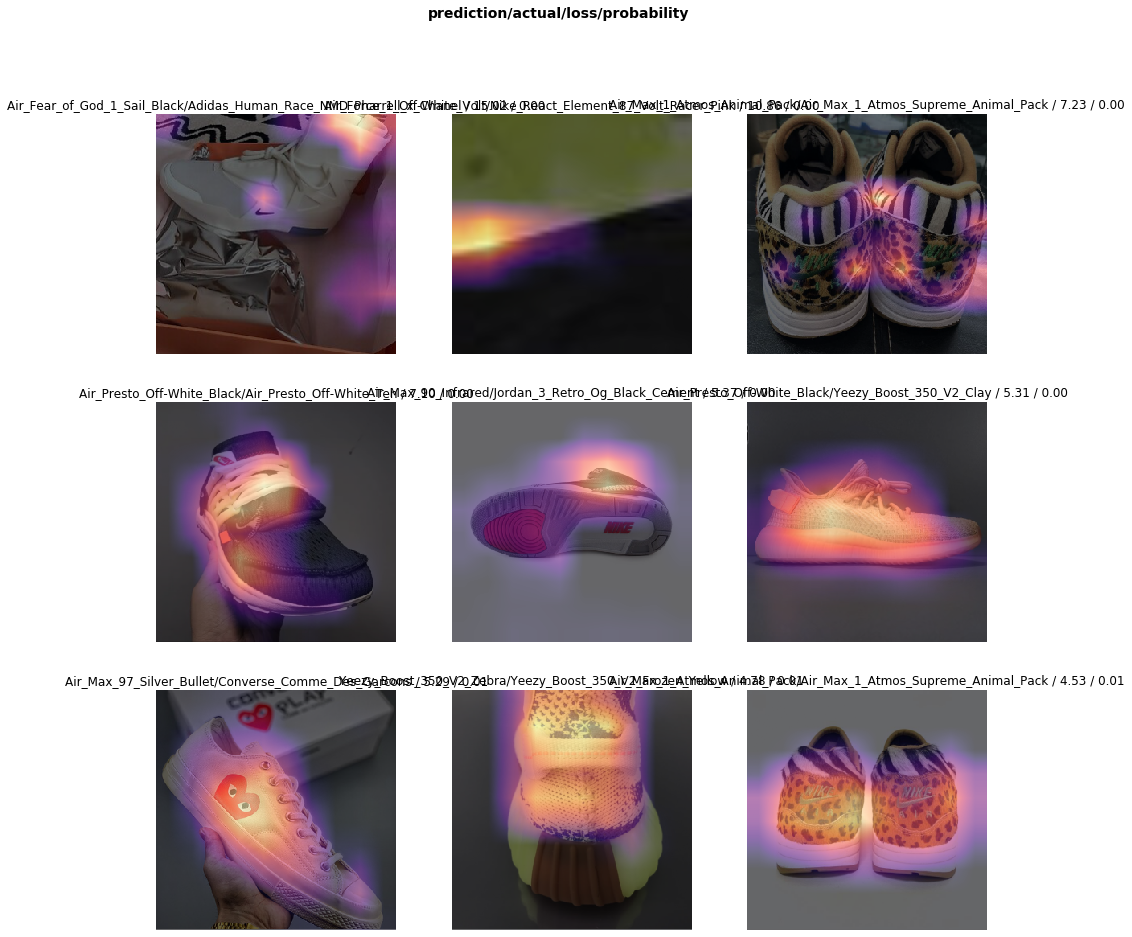

In [15]:
interp.plot_top_losses(9,figsize=(15,15))

In [16]:
doc(interp.plot_top_losses)

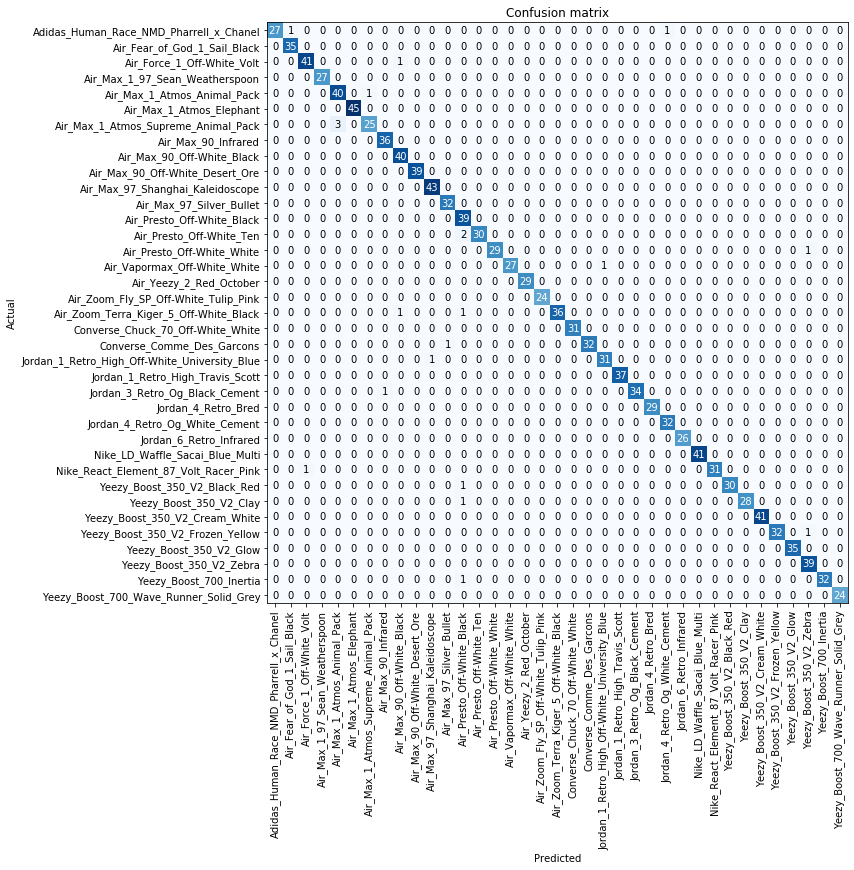

In [17]:
interp.plot_confusion_matrix(figsize=(12,12))

In [18]:
doc(interp.plot_confusion_matrix)

In [ ]:
interp.most_confused(min_val=2)

## Unfreezing, fine-tuning, and learning rates

Since our model is working, we will *unfreeze* our model, tune, and train some more.

In [20]:
learn2.unfreeze

<bound method Learner.unfreeze of Learner(data=ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Air_Max_97_Shanghai_Kaleidoscope,Air_Max_97_Shanghai_Kaleidoscope,Air_Max_97_Shanghai_Kaleidoscope,Air_Max_97_Shanghai_Kaleidoscope,Air_Max_97_Shanghai_Kaleidoscope
Path: dataset/sneakers-cropped;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Air_Max_97_Silver_Bullet,Jordan_4_Retro_Og_White_Cement,Jordan_4_Retro_Bred,Air_Max_90_Off-White_Black,Air_Zoom_Terra_Kiger_5_Off-White_Black
Path: dataset/sneakers-cropped;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace

In [21]:
# Second training session with 8 epochs!
learn2.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.035371,0.082688,0.011200,01:31
1,0.050424,0.095576,0.015200,01:32
2,0.077335,0.096432,0.016000,01:30
3,0.076981,0.101543,0.022400,01:31
4,0.054467,0.081962,0.016000,01:31
5,0.026397,0.073275,0.013600,01:30
6,0.019762,0.068124,0.012800,01:32
7,0.011371,0.070959,0.013600,01:31


In [22]:
learn2.load('stage-1-res101')

Learner(data=ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Air_Max_97_Shanghai_Kaleidoscope,Air_Max_97_Shanghai_Kaleidoscope,Air_Max_97_Shanghai_Kaleidoscope,Air_Max_97_Shanghai_Kaleidoscope,Air_Max_97_Shanghai_Kaleidoscope
Path: dataset/sneakers-cropped;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Air_Max_97_Silver_Bullet,Jordan_4_Retro_Og_White_Cement,Jordan_4_Retro_Bred,Air_Max_90_Off-White_Black,Air_Zoom_Terra_Kiger_5_Off-White_Black
Path: dataset/sneakers-cropped;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3

In [23]:
learn2.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


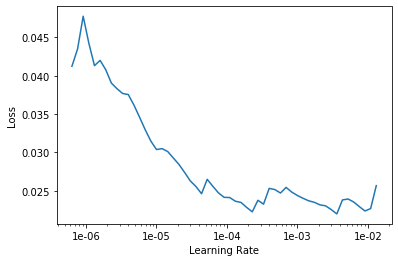

In [24]:
learn2.recorder.plot()

In [25]:
learn2.unfreeze()
learn2.fit_one_cycle(12, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.025554,0.055921,0.009600,01:32
1,0.026963,0.061541,0.011200,01:33
2,0.025245,0.052819,0.009600,01:32
3,0.024695,0.054357,0.009600,01:32
4,0.014892,0.053045,0.011200,01:31
5,0.016060,0.049527,0.011200,01:35
6,0.010462,0.045009,0.008800,01:32
7,0.009713,0.046574,0.008000,01:33
8,0.009322,0.048395,0.009600,01:34
9,0.008448,0.045276,0.008000,01:33


We'll go ahead and visualize some of our results again: confusion matrix and top loss probability chart.

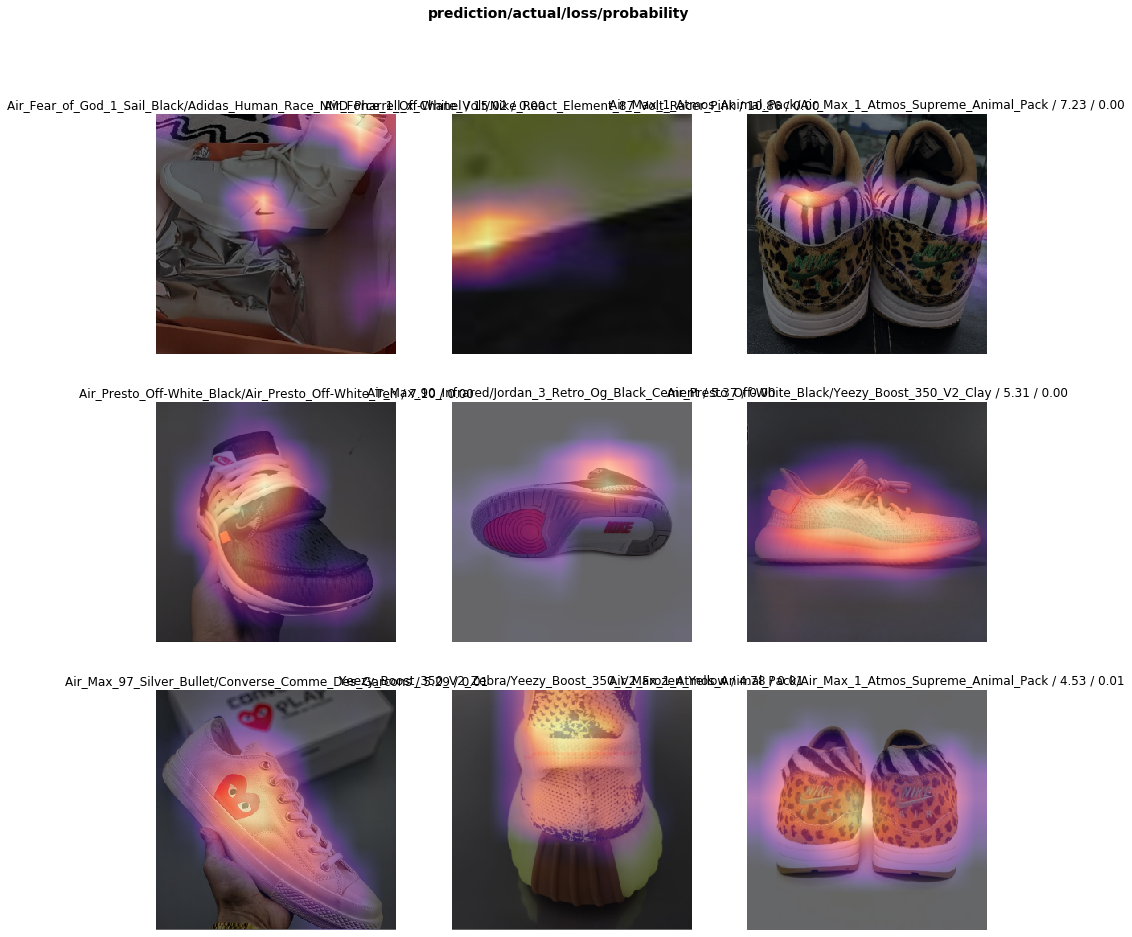

In [26]:
interp.plot_top_losses(9,figsize=(15,15))

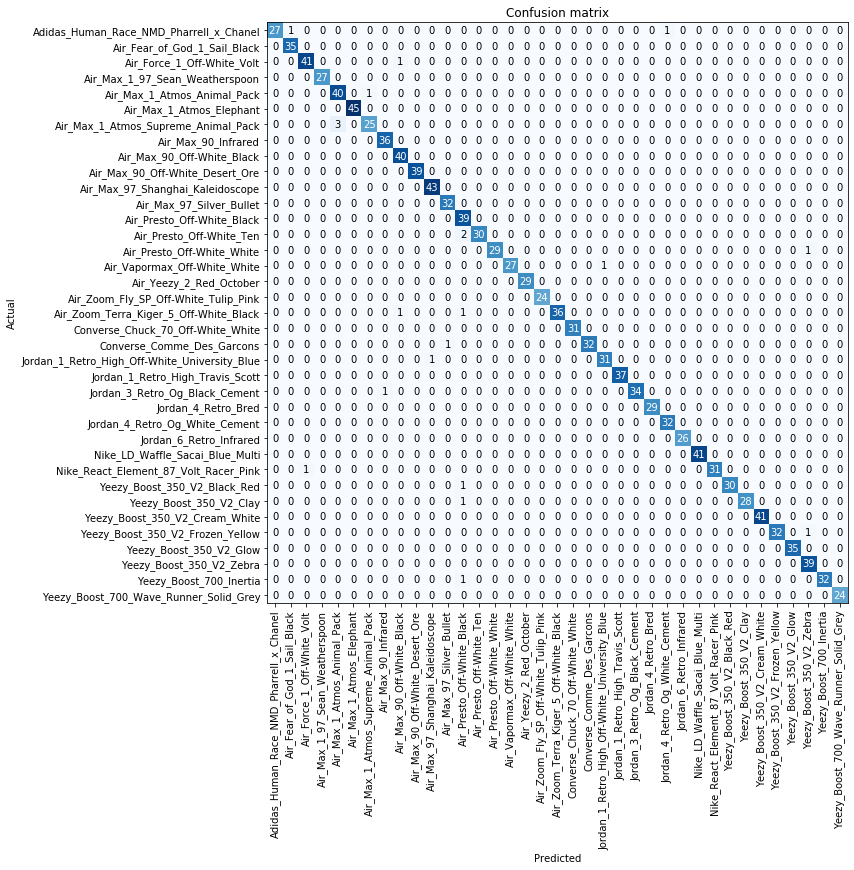

In [27]:
interp.plot_confusion_matrix(figsize=(12,12))

In [28]:
interp.most_confused(min_val=2)

[('Air_Max_1_Atmos_Supreme_Animal_Pack', 'Air_Max_1_Atmos_Animal_Pack', 3),
 ('Air_Presto_Off-White_Ten', 'Air_Presto_Off-White_Black', 2)]

## Putting model into production!

First we'll export the contents of our `Learner` object for production!

In [29]:
learn2.export()

This will create a file named 'export.pkl' in the working directory that contains everything we need to deploy our model ( the model, the weights, some metadata like the classes or the transforms/normalization used ).

Once the learner has been exported let's begin some local testing. We'll use a CPU for inferencing our test sneaker images. Feel free to add your own test sneaker images in the `test_images` folder!

In [30]:
defaults.device = torch.device('cpu')

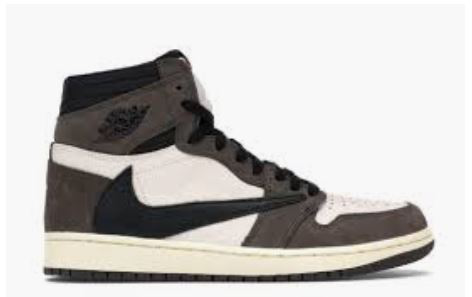

In [31]:
img = open_image(Path('test_images')/'jordan_ts_test.jpg')
img

We create our `Learner` in production the enviromnent using the following function. Make sure that `path` contains the file 'export.pkl' from before.

In [32]:
learn = load_learner(path)

In [33]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category Jordan_1_Retro_High_Travis_Scott

Lets get the top 3 prediction probabilities and plot them on a bar chart for comparsion. We'll also convert our probablities to numpy array to remove the 'tensor'. 

[('Jordan 1 Retro High Travis Scott', 0.9999639), ('Air Max 90 Off-White Black', 2.2445016e-05), ('Yeezy Boost 700 Wave Runner Solid Grey', 6.8402014e-06)]


<Figure size 576x576 with 0 Axes>

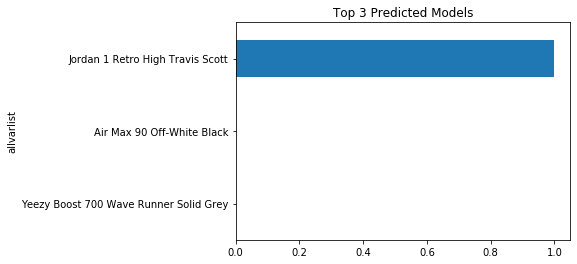

In [34]:
pred = learn.predict(img)
pred_result = pred[2].sort(descending=True)
top_3_pred_probs = pred_result[0][:3]

top_3_pred_probs = top_3_pred_probs.numpy()

top_3_pred_class_idxs = pred_result[1][:3]

# Convert label from 'air_jordan_3' to 'Air Jordan 3' after looking up proper index
top_3_pred_classes = [learn.data.classes[i].replace('_', ' ').title() for i in top_3_pred_class_idxs]

pred_top_3_output = list(zip(top_3_pred_classes, top_3_pred_probs))
print(pred_top_3_output)

plt.figure(figsize=(8,8))
df=pd.DataFrame({'allvarlist':top_3_pred_classes,'importances': top_3_pred_probs})
df.sort_values('importances',inplace=True)
df.plot(kind='barh',y='importances',x='allvarlist', legend=False, title='Top 3 Predicted Models');

# Package and store model in S3

In [41]:
import os
import io
import tarfile
import PIL
import boto3

In [42]:
# Create a clases text for pytorch model
save_texts(path/'models/classes.txt', data.classes)

In [43]:
learn.model.float()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [44]:
# Save stage-3-101 model into a format for pytorch model application
trace_input = torch.ones(1,3,499,499).cuda()
jit_model = torch.jit.trace(learn.model.cuda(), trace_input)
model_file='sneaker_wiz_model_res101.pth'
output_path = str(path/f'models/{model_file}')
torch.jit.save(jit_model, output_path)

In [45]:
tar_file=path/'models/model.tar.gz'
classes_file='classes.txt'
with tarfile.open(tar_file, 'w:gz') as f:
    f.add(path/f'models/{model_file}', arcname=model_file)
    f.add(path/f'models/{classes_file}', arcname=classes_file)

In [46]:
s3 = boto3.resource('s3')
s3.meta.client.upload_file(str(tar_file), 'fastai-data-bucket', 'models/modelres101.tar.gz')